In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
from IPython.display import Audio 
from IPython.core.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.np_utils import to_categorical

from keras import Input
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

import os
from collections import Counter
from datetime import datetime

In [2]:
num_rows = n_mfcc = 40
num_columns = max_pad_len = 431
num_channels = 1

In [20]:
def extract_features(file_name):
    try:
        y, sr = librosa.load(file_name, res_type='kaiser_fast') 
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        pad_width = max_pad_len - mfcc.shape[1]
        if pad_width > 0:
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif pad_width < 0:
            mfcc = np.delete(mfcc, -pad_width, axis=1)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e)
        return None 
     
    return mfcc

In [21]:
def fetchDataset(path, class_label):
    features = []
    filename_list = []
    for dirpath, dirnames, filenames in os.walk(path):
        print(dirpath)
        filename_list = filename_list + filenames
        for filename in filenames:
            file_name = os.path.join(dirpath, filename)
            data = extract_features(file_name)
            features.append([data, class_label])
    return features, filename_list

# 특징 직접 추출

In [ ]:
# 여기는 각자 경로에 맞게
generalSoundPath = 'E:/Audio-TrainDataset/General-Sounds/'
legalVoicePath = 'E:/Audio-TrainDataset/Legal-Voices/'
illegalVoicePath = 'E:/Audio-TrainDataset/Illegal-Voices/'
noSoundPath = 'E:/Audio-TrainDataset/No-Sounds/'

start = datetime.now()

gs, gs_name = fetchDataset(generalSoundPath, 'General Sound')
lv, lv_name = fetchDataset(legalVoicePath, 'Legal Voice')
iv, iv_name = fetchDataset(illegalVoicePath, 'Illegal Voice')
# ns, ns_name = fetchDataset(noSoundPath, 'No Sound')

duration = datetime.now() - start
print(duration)

In [ ]:
# 문제아 테스트
# extract_features('E:/Audio-TrainDataset/No-Sounds/NS-0-000000.wav')

# 추출한 특징 파일로 저장

In [ ]:
def write_features(file_name, dataset):
    with open(file_name, 'w') as f:
        for item1 in dataset:
            for item2 in item1[0]:
                for item3 in item2:
                    f.write("%s " % item3)
                f.write('\n')

def write_filenames(file_name, name_list):
    with open(file_name, 'w') as f:
        for item1 in name_list:
            f.write("%s\n" % item1)

In [ ]:
write_features('E:/특징 추출/mfcc (40, 431)/General-Sounds.txt', gs)
write_features('E:/특징 추출/mfcc (40, 431)/Legal-Voices.txt', lv)
write_features('E:/특징 추출/mfcc (40, 431)/Illegal-Voices.txt', iv)
# write_features('E:/특징 추출/mfcc (40, 431)/No-Sounds.txt', ns)

# write_filenames('E:/파일명/General-Sounds.txt', gs_name)
# write_filenames('E:/파일명/Legal-Voices.txt', lv_name)
# write_filenames('E:/파일명/Illegal-Voices.txt', iv_name)
# write_filenames('E:/파일명/No-Sounds.txt', ns_name)

# 저장한 특징 불러오기

In [3]:
def read_features(file_name, feature_label):
    dataset = []
    with open(file_name, 'r') as f:
        line = ''
        while True:
            temp = np.array([])
            for i in range(n_mfcc):
                line = f.readline()
                if not line:
                    break
                temp = np.append(temp, np.fromiter(line.split(), dtype=np.float32))
            if not line:
                break
            temp = np.reshape(temp, (n_mfcc, max_pad_len))
            dataset.append([temp, feature_label])
    return dataset

def read_filenames(file_name):
    name_list = []
    with open(file_name, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break
            name_list.append(line[:-1])
    return name_list

In [4]:
gs = read_features('E:/특징 추출/mfcc (40, 431)/General-Sounds.txt', 'General Sound')
lv = read_features('E:/특징 추출/mfcc (40, 431)/Legal-Voices.txt', 'Legal Voice')
iv = read_features('E:/특징 추출/mfcc (40, 431)/Illegal-Voices.txt', 'Illegal Voice')
# ns = read_features('E:/특징 추출/mfcc (40, 431)/No-Sounds.txt', 'No Sound')

# gs_name = read_filenames('E:/파일명/General-Sounds.txt')
# lv_name = read_filenames('E:/파일명/Legal-Voices.txt')
# iv_name = read_filenames('E:/파일명/Illegal-Voices.txt')
# ns_name = read_filenames('E:/파일명/No-Sounds.txt')

# 데이터셋 학습에 쓸 수 있게 나누고 형태 맞추는 부분

In [5]:
features = gs + lv + iv
# features = gs + lv + iv + ns
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
print('Finished feature extraction from', len(featuresdf), 'files')

Finished feature extraction from 91066 files


In [6]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

X = X.reshape(X.shape[0], num_rows, num_columns, num_channels)

In [8]:
# gs = lv = iv = features = featuresdf = y = None

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
# X = yy = None
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state = 42)

print(Counter(np.argmax(y_train, axis=1)))
print(Counter(np.argmax(y_val, axis=1)))
print(Counter(np.argmax(y_test, axis=1)))

Counter({0: 26471, 2: 24146, 1: 4022})
Counter({0: 8906, 2: 7949, 1: 1358})
Counter({0: 8801, 2: 8134, 1: 1279})


# 모델 학습 부분

In [12]:
# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(y_train.shape[1], activation='softmax'))

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [14]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 39, 430, 16)       80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 19, 215, 16)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 19, 215, 16)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 214, 32)       2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 107, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 9, 107, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 106, 64)       

In [15]:
num_epochs = 1000
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/least_val_loss_cnn_model.h5',
                               monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15)

start = datetime.now()

history = model.fit(x_train, y_train,
                    batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpointer, early_stopping_callback],
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

model.save('saved_models/last_cnn_model.h5')

Epoch 1/1000
214/214 [==============================] - 313s 1s/step - loss: 0.8518 - accuracy: 0.7192 - val_loss: 0.4300 - val_accuracy: 0.8263

Epoch 00001: val_loss improved from inf to 0.42996, saving model to saved_models\least_val_loss_cnn_model.h5
Epoch 2/1000
214/214 [==============================] - 315s 1s/step - loss: 0.3649 - accuracy: 0.8514 - val_loss: 0.3762 - val_accuracy: 0.8602

Epoch 00002: val_loss improved from 0.42996 to 0.37619, saving model to saved_models\least_val_loss_cnn_model.h5
Epoch 3/1000
214/214 [==============================] - 336s 2s/step - loss: 0.3047 - accuracy: 0.8781 - val_loss: 0.3559 - val_accuracy: 0.8716

Epoch 00003: val_loss improved from 0.37619 to 0.35594, saving model to saved_models\least_val_loss_cnn_model.h5
Epoch 4/1000
214/214 [==============================] - 352s 2s/step - loss: 0.2758 - accuracy: 0.8911 - val_loss: 0.3319 - val_accuracy: 0.8811

Epoch 00004: val_loss improved from 0.35594 to 0.33190, saving model to saved_mod

214/214 [==============================] - 310s 1s/step - loss: 0.1071 - accuracy: 0.9617 - val_loss: 0.1485 - val_accuracy: 0.9439

Epoch 00036: val_loss did not improve from 0.13198
Epoch 37/1000
214/214 [==============================] - 309s 1s/step - loss: 0.1054 - accuracy: 0.9620 - val_loss: 0.1455 - val_accuracy: 0.9499

Epoch 00037: val_loss did not improve from 0.13198
Epoch 38/1000
214/214 [==============================] - 307s 1s/step - loss: 0.1041 - accuracy: 0.9622 - val_loss: 0.1404 - val_accuracy: 0.9497

Epoch 00038: val_loss did not improve from 0.13198
Epoch 39/1000
214/214 [==============================] - 306s 1s/step - loss: 0.1058 - accuracy: 0.9620 - val_loss: 0.1345 - val_accuracy: 0.9472

Epoch 00039: val_loss did not improve from 0.13198
Epoch 40/1000
214/214 [==============================] - 307s 1s/step - loss: 0.1026 - accuracy: 0.9631 - val_loss: 0.1330 - val_accuracy: 0.9545

Epoch 00040: val_loss did not improve from 0.13198
Epoch 41/1000
214/214 [=

214/214 [==============================] - 331s 2s/step - loss: 0.0729 - accuracy: 0.9733 - val_loss: 0.1014 - val_accuracy: 0.9628

Epoch 00074: val_loss did not improve from 0.09624
Epoch 75/1000
214/214 [==============================] - 332s 2s/step - loss: 0.0735 - accuracy: 0.9730 - val_loss: 0.1152 - val_accuracy: 0.9591

Epoch 00075: val_loss did not improve from 0.09624
Epoch 76/1000
214/214 [==============================] - 348s 2s/step - loss: 0.0714 - accuracy: 0.9734 - val_loss: 0.1068 - val_accuracy: 0.9629

Epoch 00076: val_loss did not improve from 0.09624
Epoch 77/1000
214/214 [==============================] - 337s 2s/step - loss: 0.0736 - accuracy: 0.9737 - val_loss: 0.1130 - val_accuracy: 0.9598

Epoch 00077: val_loss did not improve from 0.09624
Epoch 78/1000
214/214 [==============================] - 335s 2s/step - loss: 0.0683 - accuracy: 0.9748 - val_loss: 0.0961 - val_accuracy: 0.9647

Epoch 00078: val_loss improved from 0.09624 to 0.09613, saving model to sav

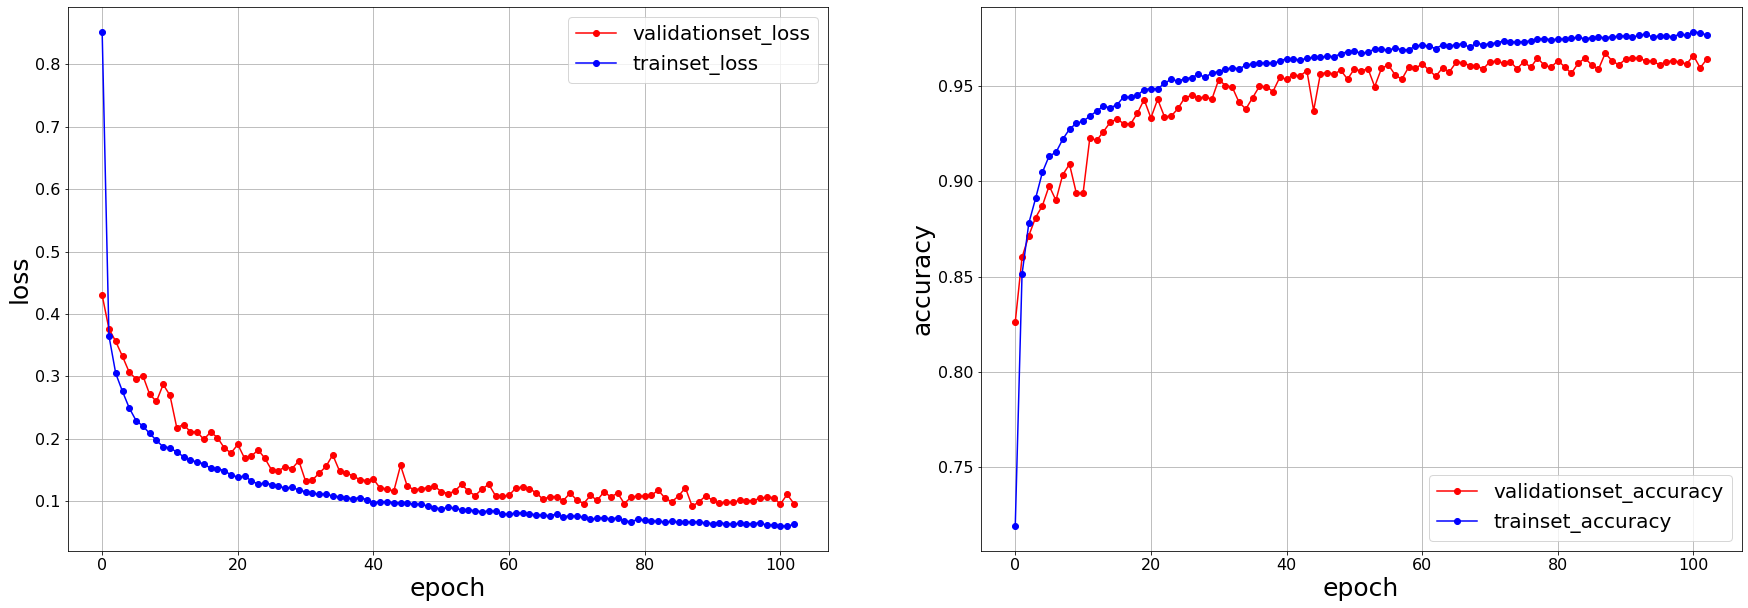

In [16]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_loss))

plt.rcParams["figure.figsize"] = (30, 10)

plt.subplot(1, 2, 1)
plt.plot(x_len, y_vloss, marker='o', c='red', label='validationset_loss')
plt.plot(x_len, y_loss, marker='o', c='blue', label='trainset_loss')
plt.legend(loc='upper right', fontsize=20)
plt.grid()
plt.xlabel('epoch', fontsize=25)
plt.ylabel('loss', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(x_len, y_vacc, marker='o', c='red', label='validationset_accuracy')
plt.plot(x_len, y_acc, marker='o', c='blue', label='trainset_accuracy')
plt.legend(loc='lower right', fontsize=20)
plt.grid()
plt.xlabel('epoch', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

# 저장된 모델 불러오기

In [ ]:
# model = load_model('saved_models/least_val_loss_cnn_model.h5')
model = load_model('saved_models/last_cnn_model.h5')

# 모델 성능 측정

In [17]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_val, y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.983125627040863
Validation Accuracy:  0.9643111824989319
Testing Accuracy:  0.9646974802017212


In [58]:
def plotConfusionMat(true, pred, labelEncoder):
    confusion_mat = confusion_matrix(true, pred)
    confusion_mat_sum = confusion_mat.sum(axis=1)[:, np.newaxis]
    confusion_mat_sum = np.where(confusion_mat_sum == 0, 1, confusion_mat_sum)
    ratio_mat = confusion_mat.astype('float') / confusion_mat_sum
    
    plt.rcParams["figure.figsize"] = (10, 10)
    
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', fontsize=30)
    plt.xlabel('Predicted labels', fontsize=20)
    plt.ylabel('True labels', fontsize=20)
    
    ticks = np.arange(len(labelEncoder.classes_))
    plt.xticks(ticks, labelEncoder.classes_)
    plt.yticks(ticks, labelEncoder.classes_)
    plt.colorbar()
    
    thresh = confusion_mat.max() / 2
    for i in range(len(labelEncoder.classes_)):
        for j in range(len(labelEncoder.classes_)):
            plt.text(j, i, "{:0.4f}\n({})".format(ratio_mat[i, j], confusion_mat[i, j]),
                     ha="center", va="center",
                     color="white" if confusion_mat[i, j] > thresh else "black",
                     fontsize=18)
    
    plt.show()

['General Sound' 'Illegal Voice' 'Legal Voice']


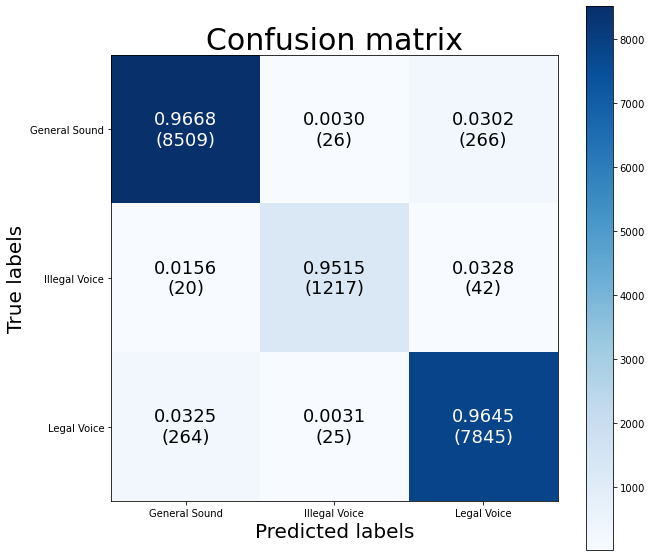

               precision    recall  f1-score   support

General Sound       0.97      0.97      0.97      8801
Illegal Voice       0.96      0.95      0.96      1279
  Legal Voice       0.96      0.96      0.96      8134

     accuracy                           0.96     18214
    macro avg       0.96      0.96      0.96     18214
 weighted avg       0.96      0.96      0.96     18214



In [19]:
# 테스트셋에 대한 혼동행렬

print(le.classes_)

y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
plotConfusionMat(y_true, y_pred, le)

print(classification_report(y_true, y_pred, target_names=le.classes_))

# 한 파일에 대한 예측 보기

In [ ]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name).reshape(1, num_rows, num_columns, num_channels)
    predicted_proba_vector = model.predict(prediction_feature)
    
    predicted_class_vector = np.argmax(predicted_proba_vector, axis=-1)
    predicted_class = le.inverse_transform(predicted_class_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        print(le.classes_[i], "\t\t : ", format(predicted_proba[i], '.32f') )

In [ ]:
filename = '102105-3-0-0.wav'

display(Audio(filename, autoplay=True))
print_prediction(filename)

# 전체 데이터셋에 대한 예측 상세히 보기

In [ ]:
gsDf = pd.DataFrame(gs, columns=['feature','class_label'])
lvDf = pd.DataFrame(lv, columns=['feature','class_label'])
ivDf = pd.DataFrame(iv, columns=['feature','class_label'])
# nsDf = pd.DataFrame(ns, columns=['feature','class_label'])

gs_x = np.array(gsDf.feature.tolist())
lv_x = np.array(lvDf.feature.tolist())
iv_x = np.array(ivDf.feature.tolist())
# ns_x = np.array(nsDf.feature.tolist())

gs_x = gs_x.reshape(gs_x.shape[0], num_rows, num_columns, num_channels)
lv_x = lv_x.reshape(lv_x.shape[0], num_rows, num_columns, num_channels)
iv_x = iv_x.reshape(iv_x.shape[0], num_rows, num_columns, num_channels)
# ns_x = ns_x.reshape(ns_x.shape[0], num_rows, num_columns, num_channels)

In [ ]:
gs_predicted = np.argmax(model.predict(gs_x), axis=-1)
lv_predicted = np.argmax(model.predict(lv_x), axis=-1)
iv_predicted = np.argmax(model.predict(iv_x), axis=-1)
# ns_predicted = np.argmax(model.predict(ns_x), axis=-1)

In [ ]:
print('General Sound')
for i, c in enumerate(gs_predicted):
    if c != 0:
        print(c, gs_name[i])
        
print('Legal Voice')
for i, c in enumerate(lv_predicted):
    if c != 2:
        print(c, lv_name[i])
        
print('Illegal Voice')
for i, c in enumerate(iv_predicted):
    if c != 1:
        print(c, iv_name[i])

# print('No Sound')
# for i, c in enumerate(ns_predicted):
#     if c != 3:
#         print(c, ns_name[i])

In [ ]:
y_pred = np.argmax(model.predict(X), axis=-1)
y_true = le.fit_transform(y)

plotConfusionMat(y_true, y_pred, le)

print(classification_report(y_true, y_pred, target_names=le.classes_))

# 특징 시각화

In [ ]:
x_values = np.arange(60)

plt.rcParams["figure.figsize"] = (30, 10)

plt.subplot(1, 3, 1)
plt.title('General Sound', fontsize=30)
plt.ylim([-100, 100])
for x in gs:
    plt.plot(x_values, x[0])
    
plt.subplot(1, 3, 2)
plt.title('Illegal Voice', fontsize=30)
plt.ylim([-100, 100])
for x in iv:
    plt.plot(x_values, x[0])
    
plt.subplot(1, 3, 3)
plt.title('Legal Voice', fontsize=30)
plt.ylim([-100, 100])
for x in lv:
    plt.plot(x_values, x[0])

plt.show()

# 다른 데이터셋에 대해 예측

In [122]:
def predict_files_in_directory(dir_paths):
    y_pred = np.array([])
    y_true = np.array([])
    
    for i, path in enumerate(dir_paths):
        X, ignore = fetchDataset(path, '')
        X = pd.DataFrame(X)[0].tolist()
        X = np.array(X)
        X = X.reshape(X.shape[0], num_rows, num_columns, num_channels)

        y_pred = np.append(y_pred, np.argmax(model.predict(X), axis=-1), 0)
        y_true = np.append(y_true, np.repeat(i, X.shape[0]), 0)
    
    plotConfusionMat(y_true, y_pred, le)
    print(classification_report(y_true, y_pred, target_names=le.classes_))

E:/Audio-TestDataset/Test-Class3/General-Sounds
E:/Audio-TestDataset/Test-Class3/ILLegal-Voices
E:/Audio-TestDataset/Test-Class3/Legal-Voices


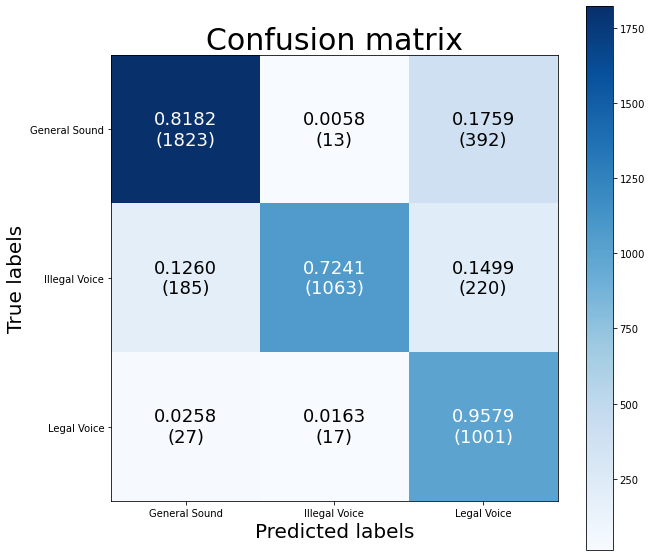

               precision    recall  f1-score   support

General Sound       0.90      0.82      0.86      2228
Illegal Voice       0.97      0.72      0.83      1468
  Legal Voice       0.62      0.96      0.75      1045

     accuracy                           0.82      4741
    macro avg       0.83      0.83      0.81      4741
 weighted avg       0.86      0.82      0.82      4741



In [123]:
gs_path = "E:/Audio-TestDataset/Test-Class3/General-Sounds"
iv_path = "E:/Audio-TestDataset/Test-Class3/ILLegal-Voices"
lv_path = "E:/Audio-TestDataset/Test-Class3/Legal-Voices"
predict_files_in_directory((gs_path, iv_path, lv_path))